<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_ppo_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
#!pip install box2d-py
import numpy as np 
import mxnet as mx 
from mxnet import gluon,autograd,nd
import mxnet.ndarray as F
from mxnet.gluon import nn
from mxnet.gluon.loss import L2Loss
import gym
from mxnet import init
import matplotlib.pyplot as plt

# hyper params

In [0]:
env_name = "CartPole-v1"
# creating environment
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
solved_reward = 500      
log_interval = 20          
max_episodes = 50000       
max_timesteps = 1000      
update_timestep = 2000  
lr = 0.001
gamma = 0.99               
K_epochs = 4           
eps_clip = 0.2

# nd_entropy

In [0]:
def nd_entropy(p):
  return -nd.sum(p*nd.log(p+1e-8),axis=1)

# nd_entropy test

In [4]:
# test nd_entropy
a = [1,0,0]
b = [0,0,1]
c = [0.4,0.3,0.3]
d = [0.7,0.2,0.1]
for i in [a,b,c,d]:
  p = nd.array([i])
  print(nd_entropy(p))


[-0.]
<NDArray 1 @cpu(0)>

[-0.]
<NDArray 1 @cpu(0)>

[1.0889001]
<NDArray 1 @cpu(0)>

[0.80181855]
<NDArray 1 @cpu(0)>


# memory

In [0]:
class Memory:
  def __init__(self):
    self.actions = []
    self.states = []
    self.logprobs = []
    self.rewards = []
    self.is_terminals = []
  
  def clear_memory(self):
    del self.actions[:]
    del self.states[:]
    del self.logprobs[:]
    del self.rewards[:]
    del self.is_terminals[:]

# ActorCritic model

In [0]:
class ActorCritic_Discrete(nn.HybridBlock):
  def __init__(self, actions_dim):
    super().__init__()
    with self.name_scope():
      self.fc1 = nn.Dense(64, activation='relu')
      self.fc2 = nn.Dense(64, activation='relu')
      self.fc3 = nn.Dense(64, activation='relu')
      self.action_pred = nn.Dense(actions_dim)
      self.value_pred = nn.Dense(1)
  
  def hybrid_forward(self,F,x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    probs = self.action_pred(x)
    values = self.value_pred(x)
    return F.softmax(probs), values

# forward test

In [7]:
env = gym.make(env_name)
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state = env.reset()
state = nd.array([state])
print(state_dim,action_dim)
a = ActorCritic_Discrete(action_dim)
b = ActorCritic_Discrete(action_dim)
a.initialize(init=init.Xavier())
b.initialize(init=init.Xavier())
a.hybridize()
b.hybridize()
print(a(state))
print(b(state))

4 2
[
[[0.5015262 0.4984738]]
<NDArray 1x2 @cpu(0)>, 
[[-0.00114449]]
<NDArray 1x1 @cpu(0)>]
[
[[0.5032659  0.49673414]]
<NDArray 1x2 @cpu(0)>, 
[[0.00484853]]
<NDArray 1x1 @cpu(0)>]


# copy params test

In [8]:
a.save_parameters("temp")
b.load_parameters("temp")
print(a(state))
print(b(state))

[
[[0.5015262 0.4984738]]
<NDArray 1x2 @cpu(0)>, 
[[-0.00114449]]
<NDArray 1x1 @cpu(0)>]
[
[[0.5015262 0.4984738]]
<NDArray 1x2 @cpu(0)>, 
[[-0.00114449]]
<NDArray 1x1 @cpu(0)>]


# model save test

In [0]:
a.export('test_save_model')

# initialize memory net old_net and trainer

In [0]:
memory = Memory()

In [0]:
net = ActorCritic_Discrete(action_dim)
old_net = ActorCritic_Discrete(action_dim)

net.initialize(init=init.Xavier())
old_net.initialize(init=init.Xavier())

net.hybridize()
old_net.hybridize()

net(state)
old_net(state)

net.save_parameters("temp")
old_net.load_parameters("temp")

In [0]:
trainer = gluon.Trainer(net.collect_params(),'adam',{'learning_rate':lr})

# main loop

In [13]:
all_rewards = []
avg_rewards = []
time_step = 0

for i_episode in range(max_episodes):
  
  state = env.reset()
  R = 0
  
  for t in range(max_timesteps):
    time_step +=1
    
    # interactive with env
    probs, values = old_net(nd.array([state]))
    action, log_prob = nd.sample_multinomial(probs, get_prob = True)
    action, log_prob = action.asnumpy()[0], log_prob.asnumpy()[0]
    next_state, reward, done, info = env.step(action)
    
    # append to memory
    R += reward
    memory.states.append(state)
    memory.actions.append(action)
    memory.logprobs.append(log_prob)
    memory.rewards.append(reward)
    memory.is_terminals.append(done)
    
    # every update_timestep ppo learn
    if time_step % update_timestep == 0:
      
      # Monte Carlo estimate of state rewards:
      rewards = []
      discounted_reward = 0
      for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
        if is_terminal:
          discounted_reward = 0
        discounted_reward = reward + (gamma * discounted_reward)
        rewards.insert(0, discounted_reward)
      
      # Normalizing the rewards:
      rewards = np.array(rewards)
      rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
      rewards = nd.array(rewards)

      # sample batch data from memory
      old_states = nd.array(memory.states)
      old_actions = nd.array(memory.actions)
      old_logprobs = nd.array(memory.logprobs)

      # Optimize policy for 4 epochs:
      for _ in range(K_epochs):
        with autograd.record():
          probs, values = net(old_states)
          logprobs = nd.pick(probs.log(),old_actions,axis=1)
          dist_entropy = nd_entropy(probs)
          values = nd.squeeze(values)
          # caculate
          ratios = nd.exp(logprobs - old_logprobs)
          advantages = rewards - values
          surr1 = ratios * advantages
          surr2 = nd.clip(ratios,1-eps_clip,1+eps_clip)*advantages
          loss = -nd.minimum(surr1,surr2) + 0.5*nd.mean((advantages)**2) - 0.01*dist_entropy
          loss = nd.mean(loss)
        loss.backward()
        trainer.step(1)
      net.save_parameters("temp")
      old_net.load_parameters("temp")
      print('copy params to old net')
      memory.clear_memory()
      time_step = 0
    
    # game over
    if done:
      break
    else:
      state = next_state            
  
  # every episode record R
  all_rewards.append(R)
  avg_rewards.append(np.mean(all_rewards[-log_interval:]))
  
  # if solved!
  if (all_rewards[-1] >= solved_reward):#&(avg_rewards[-1] >= solved_reward*0.9):
    print("########## Solved! ##########")
    print(i_episode,all_rewards[-1],avg_rewards[-1])
    break
  
  # print infomation
  if i_episode % log_interval == 0:
    print(i_episode,avg_rewards[-1])

0 11.0
20 23.85
40 27.55
60 18.95
80 20.9
copy params to old net
100 22.7
120 22.45
140 20.9
160 23.35
copy params to old net
180 26.0
200 23.15
220 23.55
240 29.85
copy params to old net
260 23.7
280 26.9
300 25.3
320 23.4
copy params to old net
340 28.95
360 25.4
380 24.5
400 28.4
copy params to old net
420 24.55
440 23.65
460 30.0
480 29.0
copy params to old net
500 33.5
520 29.15
540 28.8
copy params to old net
560 33.6
580 37.75
600 29.8
copy params to old net
620 39.1
640 42.15
copy params to old net
660 35.9
680 43.0
700 42.2
copy params to old net
720 38.85
740 33.55
760 35.1
copy params to old net
780 38.5
800 46.8
copy params to old net
820 37.95
840 36.8
copy params to old net
860 61.95
880 59.65
copy params to old net
900 61.3
920 47.45
copy params to old net
940 77.35
copy params to old net
960 43.7
980 72.45
copy params to old net
1000 113.2
copy params to old net
1020 77.65
copy params to old net
1040 104.2
copy params to old net
1060 114.15
copy params to old net
copy p

# plot

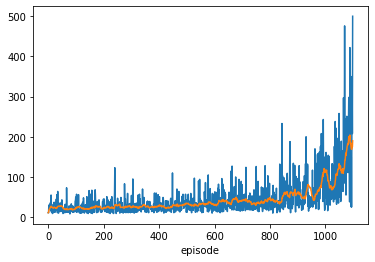

In [14]:
plt.plot(all_rewards)
plt.plot(avg_rewards)
plt.xlabel('episode')
plt.show()

# save model

In [0]:
old_net.export('{}_model'.format(env_name))
del old_net

# load model

In [16]:
deserialized_net = nn.SymbolBlock.imports("{}_model-symbol.json".format(env_name), 
                                          ['data'], 
                                          "{}_model-0000.params".format(env_name))

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


# test model

In [18]:
env = gym.make(env_name)
old_net = deserialized_net
for i_episode in range(10):
  state = env.reset()
  R = 0
  for t in range(1000):
    probs,values = old_net(nd.array([state]))
    action = np.argmax(probs.asnumpy())
    state, reward, done, info = env.step(action)
    R += reward
    if done:
      break            
  print(i_episode,R)

0 500.0
1 500.0
2 500.0
3 500.0
4 500.0
5 500.0
6 421.0
7 463.0
8 500.0
9 500.0
